# Testing

In [1]:
# Simplification of: https://github.com/binance/binance-public-data/tree/master/python

import pandas as pd
from datetime import *
from dateutil.rrule import rrule, MONTHLY

import os, sys
from pathlib import Path
import urllib.request


YEARS = ['2017', '2018', '2019', '2020', '2021']
INTERVALS = ["1m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1mo"]
DAILY_INTERVALS = ["1m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d"]
TRADING_TYPE = ["spot", "um", "cm"]
MONTHS = list(range(1,13))
MAX_DAYS = 35
BASE_URL = 'https://data.binance.vision/'
START_DATE = date(int(YEARS[0]), MONTHS[0], 1)
END_DATE = datetime.date(datetime.now())


def get_destination_dir(file_url, folder=None):
  # store_directory = os.environ.get('STORE_DIRECTORY')
  # if folder:
  #   store_directory = folder
  # if not store_directory:
  #   store_directory = os.path.dirname(os.path.realpath(__file__))
  return os.path.join('', file_url)


def get_download_url(file_url):
  return "{}{}".format(BASE_URL, file_url)


def download_file(base_path, file_name, date_range=None, folder=None):
  download_path = "{}{}".format(base_path, file_name)
  if folder:
    base_path = os.path.join(folder, base_path)
  if date_range:
    date_range = date_range.replace(" ","_")
    base_path = os.path.join(base_path, date_range)
  save_path = get_destination_dir(os.path.join(base_path, file_name), folder)
  

  if os.path.exists(save_path):
    print("\nfile already exists! {}".format(save_path))
    return
  
  # make the directory
  if not os.path.exists(base_path):
    Path(get_destination_dir(base_path)).mkdir(parents=True, exist_ok=True)

  try:
    download_url = get_download_url(download_path)
    dl_file = urllib.request.urlopen(download_url)
    length = dl_file.getheader('content-length')
    if length:
      length = int(length)
      blocksize = max(4096,length//100)

    with open(save_path, 'wb') as out_file:
      dl_progress = 0
      print("\nFile Download: {}".format(save_path))
      while True:
        buf = dl_file.read(blocksize)   
        if not buf:
          break
        dl_progress += len(buf)
        out_file.write(buf)
        done = int(50 * dl_progress / length)
        sys.stdout.write("\r[%s%s]" % ('#' * done, '.' * (50-done)) )    
        sys.stdout.flush()

  except urllib.error.HTTPError:
    print("\nFile not found: {}".format(download_url))
    pass

def convert_to_date_object(d):
  year, month, day = [int(x) for x in d.split('-')]
  date_obj = date(year, month, day)
  return date_obj

def get_path(trading_type, market_data_type, time_period, symbol, interval=None):
  trading_type_path = 'data/spot'
  if trading_type != 'spot':
    trading_type_path = f'data/futures/{trading_type}'
  if interval is not None:
    path = f'{trading_type_path}/{time_period}/{market_data_type}/{symbol.upper()}/{interval}/'
  else:
    path = f'{trading_type_path}/{time_period}/{market_data_type}/{symbol.upper()}/'
  return path


def download_monthly_klines(trading_type, symbols, num_symbols, intervals, years, months, start_date, end_date, folder, checksum):
  current = 0
  date_range = None

  # if start_date and end_date:
  #   date_range = start_date + " " + end_date

  if not start_date:
    start_date = START_DATE
  else:
    start_date = convert_to_date_object(start_date)

  if not end_date:
    end_date = END_DATE
  else:
    end_date = convert_to_date_object(end_date)

  print("Found {} symbols".format(num_symbols))

  for symbol in symbols:
    print("[{}/{}] - start download monthly {} klines ".format(current+1, num_symbols, symbol))
    for interval in intervals:
      for year in years:
        for month in months:
          current_date = convert_to_date_object('{}-{}-01'.format(year, month))
          if current_date >= start_date and current_date <= end_date:
            path = get_path(trading_type, "klines", "monthly", symbol, interval)
            file_name = "{}-{}-{}-{}.zip".format(symbol.upper(), interval, year, '{:02d}'.format(month))
            download_file(path, file_name, date_range, folder)

            if checksum == 1:
              checksum_path = get_path(trading_type, "klines", "monthly", symbol, interval)
              checksum_file_name = "{}-{}-{}-{}.zip.CHECKSUM".format(symbol.upper(), interval, year, '{:02d}'.format(month))
              download_file(checksum_path, checksum_file_name, date_range, folder)

    current += 1


# CUSTOM CODE
def download_data(folder, type='spot', symbols=['BTCUSDT'], intervals=['1m'], years=YEARS, months=MONTHS, startDate=None, endDate=None, checksum=0):
    num_symbols = len(symbols)
    download_monthly_klines(type, symbols, num_symbols, intervals, years, months, startDate, endDate, folder, checksum)


def load_dataframe(folder, start_date, end_date, type='spot', symbol='BTCUSDT', interval='1m'):
  cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'close_date', 'quote_asset_volume', 'number_of_trades',	'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',	'ignore']
  path = '{}/data/{}/monthly/klines/{}/{}/'.format(folder, type, symbol, interval)

  data = []
  start, end = datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')
  rr = rrule(MONTHLY, dtstart=start, until=end)
  for p in rr:
    file_name = '{}-{}-{}-{:02d}.zip'.format(symbol, interval, p.year, p.month)
    data.append(pd.read_csv(path + file_name, names=cols))
  
  data = pd.concat(data, ignore_index=True)
  data['Date'] = pd.to_datetime(data['Date'], unit='ms')
  data['close_date'] = pd.to_datetime(data['close_date'], unit='ms')
  return data


In [2]:
import torch
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


class BaseTransform(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X


class FilterFeatures(BaseTransform):
    '''
    Devuelve un subset del dataframe de entrada unicamente con las
    features seleccionadas.
    '''
    def __init__(self, features=[]):
        self.features = features

    def transform(self, X):
        return X[self.features].copy()


class RelativeTransform(BaseTransform):
    def __init__(self, ref_col, target_cols):
        self.ref_col = ref_col
        self.target_cols = target_cols
    
    def transform(self, X):
        ref_value = X.iloc[-1][self.ref_col]
        ref_factor = 100 / ref_value
        
        X[self.target_cols] = (X[self.target_cols] * ref_factor) - 100
        return X


class ManualNormalizer(BaseTransform):
    def __init__(self, feature, mean, std):
        self.feature = feature
        self.mean = mean
        self.std = std
    
    def transform(self, X):
        X[self.feature] = (X[self.feature] - self.mean) / self.std
        return X


class ToTensorTransform(BaseTransform):
    def transform(self, X):
        return torch.tensor(X.values).transpose(0, 1)

In [3]:
import torch
import numpy as np
import mplfinance as fplt
import plotly.graph_objects as go
from torch.utils.data import Dataset, WeightedRandomSampler


PLOT_PARAMS = {
    'type': 'candle',
    'style': 'charles',
    'volume': True,
    'show_nontrading': True
}


def plot_df_simlpe(df):
    df_plot = df.copy()
    df_plot.set_index('Date', inplace=True, drop=True)
    fplt.plot(df_plot, **PLOT_PARAMS)


def plot_df_interactive(df):
    fig = go.Figure(data=[go.Candlestick(
        x=df['Date'],
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'])])
    fig.update_layout(xaxis_rangeslider_visible=False)
    # fig.show()
    return fig


def plot_by_date(df, min_date, max_date):
    df_plot = df[(df.Open >= min_date) & (df.Open < max_date)].copy()
    df_plot.set_index('Date', inplace=True, drop=True)
    fplt.plot(df_plot, **PLOT_PARAMS)


def plot_by_idx(df, min_idx, max_idx):
    df_plot = df[(df.index >= min_idx) & (df.index < max_idx)].copy()
    df_plot.set_index('Date', inplace=True, drop=True)
    fplt.plot(df_plot, **PLOT_PARAMS)


def get_class_weights(ds, n_classes):
    class_counts = {}
    binary = len(ds[0][1].size()) == 0
    for c in range(n_classes):
        class_counts[c] = 0
    
    for _, target in ds:
        if binary:
            class_counts[target.item()] += 1
        else:
            class_counts[torch.argmax(target).item()] += 1
    
    weights = []
    for c in range(n_classes):
        weights.append(1 / class_counts[c])
    
    return tuple(weights)


def get_scaled_class_weights(ds, n_classes):
    class_weights = torch.tensor(get_class_weights(ds, n_classes))
    return torch.max(class_weights) / class_weights


def get_weighted_random_sampler(ds, class_weights):
    sample_weights = []
    binary = len(ds[0][1].size()) == 0
    
    for _, target in ds:
        if binary:
            sample_weights.append(class_weights[target.item()])
        else:
            sample_weights.append(class_weights[torch.argmax(target).item()])
    
    sample_weights = torch.from_numpy(np.array(sample_weights))
    return WeightedRandomSampler(sample_weights, len(sample_weights))


class BaseTradingDataset(Dataset):
    REF_COL = 'Close'
    REF_MAX_COL = 'Close'
    REF_MIN_COL = 'Close'

    def __init__(self, df, transforms, train_window_size=25, pred_window_size=15, stride=1):
        self.df = df
        self.transforms = transforms
        self.train_window_size = train_window_size
        self.pred_window_size = pred_window_size
        self.stride = stride

        self._precomputed_data = None
        self._precomputed_target = None

    def __len__(self):
        full_window = self.train_window_size + self.pred_window_size
        return (len(self.df) - full_window + 1) // self.stride
    
    def get_label_from_target(self, price, target):
        pass

    def _get_data(self, idx, raw=False):
        start = idx * self.stride
        end = start + self.train_window_size
        data = self.df[start:end].copy()
        if not raw:
            data = self.transforms.transform(data)
        return data
    
    def _get_target(self, idx, raw=False):
        start = (idx * self.stride) + self.train_window_size
        end = start + self.pred_window_size
        target = self.df[start:end].copy()
        if not raw:
            price = self.df.iloc[start - 1][self.REF_COL]
            target = self.get_label_from_target(price, target)
        return target

    def precompute_data(self):
        data = []
        for i in range(len(self)):
            data.append(self._get_data(i))
        self._precomputed_data = torch.stack(data)
    
    def precompute_target(self):
        target = []
        for i in range(len(self)):
            target.append(self._get_target(i))
        self._precomputed_target = torch.stack(target)

    def precompute(self):
        self.precompute_data()
        self.precompute_target()
    
    def to(self, device):
        if self._precomputed_data is not None:
            self._precomputed_data = self._precomputed_data.to(device)
        if self._precomputed_target is not None:
            self._precomputed_target = self._precomputed_target.to(device)

    def __getitem__(self, idx):
        if idx >= len(self):
            raise StopIteration
        
        if self._precomputed_data is not None:
            data = self._precomputed_data[idx]
        else:
            data = self._get_data(idx)
        
        if self._precomputed_target is not None:
            target = self._precomputed_target[idx]
        else:
            target = self._get_target(idx)

        # data = torch.tensor(data.values).transpose(0, 1)
        return data, target


class BinaryTradeDataset(BaseTradingDataset):
    def __init__(self, df, transforms, threshold, increase=True, **kwargs):
        super().__init__(df, transforms, **kwargs)
        self.threshold = threshold
        self.increase = increase
    
    def update_target(self, threshold, increase, precompute=True):
        self.threshold = threshold
        self.increase = increase
        
        if precompute:
            self.precompute_target
    
    def get_label_from_target(self, price, target):
        if self.increase:
            max_value = target[self.REF_MAX_COL].max()
            diff = (max_value * 100 / price) - 100
            return torch.tensor((diff > self.threshold) * 1)
        if not self.increase:
            min_value = target[self.REF_MIN_COL].min()
            diff = (min_value * 100 / price) - 100
            return torch.tensor((diff < self.threshold) * 1)


class MulticlassTradeDataset(BaseTradingDataset):
    '''
    Multiclass target with 4 classes:
    Class 1: Upper bound broken without previously breaking lower bound
    Class 2: Lower bound broken without previously breaking upper bound
    Class 3: Else (no bound broken)
    '''
    def __init__(self, df, transforms, sup_threshold, inf_threshold, **kwargs):
        super().__init__(df, transforms, **kwargs)
        self.sup_threshold = sup_threshold
        self.inf_threshold = inf_threshold
    
    def update_target(self, sup_threshold, inf_threshold, precompute=True):
        self.sup_threshold = sup_threshold
        self.inf_threshold = inf_threshold

        if precompute:
            self.precompute_target
    
    def get_label_from_target(self, price, target):
        sup_price = price * (1 + (self.sup_threshold / 100))
        inf_price = price * (1 + (self.inf_threshold / 100))

        over = target[target[self.REF_MAX_COL] > sup_price]
        if not over.empty:
            pos = over.index[0]
            if target[target.index <= pos][self.REF_MIN_COL].min() > inf_price:
                return torch.tensor([1, 0, 0])
        
        if target[self.REF_MIN_COL].min() < inf_price:
            return torch.tensor([0, 1, 0])
            
        return torch.tensor([0, 0, 1])

In [9]:
# download_data('/Users/dirigaray/repos/crypto_bot/data', startDate='2020-01-01', endDate='2021-02-01', intervals=['15m'])

Found 1 symbols
[1/1] - start download monthly BTCUSDT klines 

File Download: /Users/dirigaray/repos/crypto_bot/data/data/spot/monthly/klines/BTCUSDT/15m/BTCUSDT-15m-2020-01.zip
[##################################################]
File Download: /Users/dirigaray/repos/crypto_bot/data/data/spot/monthly/klines/BTCUSDT/15m/BTCUSDT-15m-2020-02.zip
[##################################################]
File Download: /Users/dirigaray/repos/crypto_bot/data/data/spot/monthly/klines/BTCUSDT/15m/BTCUSDT-15m-2020-03.zip
[##################################################]
File Download: /Users/dirigaray/repos/crypto_bot/data/data/spot/monthly/klines/BTCUSDT/15m/BTCUSDT-15m-2020-04.zip
[##################################################]
File Download: /Users/dirigaray/repos/crypto_bot/data/data/spot/monthly/klines/BTCUSDT/15m/BTCUSDT-15m-2020-05.zip
[##################################################]
File Download: /Users/dirigaray/repos/crypto_bot/data/data/spot/monthly/klines/BTCUSDT/15m/BTCUS

In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import torch
# from crypto_bot.utils import save_obj, load_obj
# from crypto_bot.binance.data_utils import download_data, load_dataframe
# from crypto_bot.model.data import BinaryTradeDataset, MulticlassTradeDataset

# DATA_FOLDER = 'C:/Users/diego/crypto_bot/data'
# WEIGHTS_PATH = 'C:/Users/diego/crypto_bot/data/models'

# Download data

In [ ]:
download_data(DATA_FOLDER, startDate='2020-01-01', endDate='2022-01-01', intervals=['1h'])

Found 1 symbols
[1/1] - start download monthly BTCUSDT klines 

File not found: https://data.binance.vision//spot/monthly/klines/BTCUSDT/1h/BTCUSDT-1h-2020-01.zip

File not found: https://data.binance.vision//spot/monthly/klines/BTCUSDT/1h/BTCUSDT-1h-2020-02.zip


# Load data

In [2]:
train_df = load_dataframe(DATA_FOLDER, '2020-01-01', '2021-10-30', interval='1h')
valid_df = load_dataframe(DATA_FOLDER, '2021-11-01', '2021-12-30', interval='1h')

In [6]:
train_df.shape

(16050, 12)

# Prepare data

In [10]:
from crypto_bot.model.transforms import FilterFeatures, RelativeTransform, ManualNormalizer, ToTensorTransform
from sklearn.pipeline import Pipeline
from crypto_bot.model.data import MulticlassTradeDataset

features = ['Open', 'High', 'Low', 'Close', 'Volume']
transforms = Pipeline([
    ('filter_features', FilterFeatures(features)),
    ('relative_features', RelativeTransform('Close', ['Open', 'High', 'Low', 'Close'])),
    ('normalize_volume', ManualNormalizer('Volume', 253.104670, 294.186058)),
    ('to_tensor', ToTensorTransform()),
])

## Binary/Multiclass dataset

In [11]:
# Binary
train_dataset = BinaryTradeDataset(train_df, transforms, 0.8, stride=3)
valid_dataset = BinaryTradeDataset(valid_df, transforms, 0.8, stride=3)

# # Multiclass
# train_dataset = MulticlassTradeDataset(train_df, transforms, 0.7, -0.3, stride=1)
# valid_dataset = MulticlassTradeDataset(valid_df, transforms, 0.7, -0.3, stride=1)

train_dataset.precompute()
valid_dataset.precompute()

In [14]:
train_ds_name = '{}/data_loaders/train_5m_v1.ds'.format(DATA_FOLDER)
valid_ds_name = '{}/data_loaders/valid_5m_v1.ds'.format(DATA_FOLDER)

# Save
save_obj(train_ds_name, train_dataset)
save_obj(valid_ds_name, valid_dataset)

# # Load
# train_dataset = load_obj(train_ds_name)
# valid_dataset = load_obj(valid_ds_name)

# Load data

In [5]:
ds = load_dataframe('/Users/dirigaray/repos/crypto_bot/data', start_date='2020-12-01', end_date='2020-12-30', interval='15m')
ds.shape

(2957, 12)

In [308]:
{k: '_{}'.format(k) for k in [1,2,3]}

{1: '_1', 2: '_2', 3: '_3'}

In [69]:
# from crypto_bot.model.transforms import BaseTransform
from talib.abstract import Function


class BaseCandlestickTransform(BaseTransform):
    OPEN = 'Open'
    HIGH = 'High'
    LOW = 'Low'
    CLOSE = 'Close'
    VOLUME = 'Volume'


class TalibBaseTransform(BaseCandlestickTransform):
    '''
    Base Class for using talib functions as transforms
    https://github.com/mrjbq7/ta-lib
    '''

    def __init__(self, func_name, output_name, **kwargs):
        self.func_name = func_name
        self.output_name = output_name
        self.kwargs = kwargs
        self.f = Function(func_name)
    
    def transform(self, X):
        inputs = {
            'open': X[self.OPEN],
            'high': X[self.HIGH],
            'low': X[self.LOW],
            'close': X[self.CLOSE],
            'volume': X[self.VOLUME]
        }
        output = self.f(inputs, **self.kwargs)
        if len(output) == len(X):
            X[self.output_name] = self.f(inputs, **self.kwargs)
        else:
            names = {k: '{}_{}'.format(self.output_name, k) for k in range(len(output))}
            output = pd.DataFrame(output).transpose().rename(columns=names)
            X = pd.concat([X, output], axis=1)
        return X


class MovingAverageTransform(TalibBaseTransform):
    '''
    DEMA                 Double Exponential Moving Average
    EMA                  Exponential Moving Average
    KAMA                 Kaufman Adaptive Moving Average
    MA                   Moving average
    MAMA                 MESA Adaptive Moving Average
    MAVP                 Moving average with variable period
    SMA                  Simple Moving Average
    T3                   Triple Exponential Moving Average (T3)
    TEMA                 Triple Exponential Moving Average
    TRIMA                Triangular Moving Average
    WMA                  Weighted Moving Average
    '''
    def __init__(self, func_name, timeperiod=30, **kwargs):
        self.output_name = '{}_{}'.format(func_name.lower(), timeperiod)
        super().__init__(func_name, self.output_name, timeperiod=timeperiod, **kwargs)


class CrossBaseTransform(BaseCandlestickTransform):
    '''
    Calculates when 2 columns values cross one each other
    (the larger one changes from the previous candle to the next one)
    '''
    def __init__(self, col_a, col_b, result):
        self.col_a = col_a
        self.col_b = col_b
        self.result = result
    
    def transform(self, X):
        r = [0]
        for i in range(1, len(X)):
            r1 = X.iloc[i - 1]
            r2 = X.iloc[i]
            r.append(int(r1[self.col_a] < r1[self.col_b] and r2[self.col_a] > r2[self.col_b]))

        X[self.result] = r
        return X


class MAWithCrossesTransform(BaseCandlestickTransform):
    def __init__(self, func_name, short, long, **kwargs):
        if short >= long:
            raise Exception('"short" timeperiod must be smaller than "long".')
        self.func_name = func_name
        self.short = short
        self.long = long

        short_col = '{}_{}'.format(func_name.lower(), short)
        long_col = '{}_{}'.format(func_name.lower(), long)
        cross_col = '{}_{}_{}_'.format(func_name.lower(), short, long)
        self.pipe = Pipeline([
            ('short', MovingAverageTransform(func_name, short, **kwargs)),
            ('long', MovingAverageTransform(func_name, long, **kwargs)),
            ('golden', CrossBaseTransform(short_col, long_col, cross_col + 'golden-cross')),
            ('death', CrossBaseTransform(long_col, short_col, cross_col + 'death-cross'))
        ])
    
    def transform(self, X):
        return self.pipe.transform(X)


class LocalMinMaxBaseTransform(BaseCandlestickTransform):
    FUNC = None

    def __init__(self, steps=5):
        self.steps = steps
        self.radius = int((steps / 2) if (steps % 2 == 0) else ((steps - 1) / 2))
        self.result_name = 'local{}_{}'.format(self.FUNC, steps)
    
    def transform(self, X):
        i = self.radius
        indexes = []
        values = []
        prices = X[self.CLOSE]
        
        while i < len(X) - self.radius:
            if prices.iloc[i] == getattr(prices.iloc[(i - self.radius):(i + self.radius + 1)], self.FUNC)():
                indexes.append(i)
                values.append(prices.iloc[i])
                i += self.radius + 1
            else:
                i += 1
        
        X[self.result_name] = pd.Series(values, index=indexes)
        return X


class LocalMinTransform(LocalMinMaxBaseTransform):
    FUNC = 'min'


class LocalMaxTransform(LocalMinMaxBaseTransform):
    FUNC = 'max'


class MovingWindowBaseTransform(BaseCandlestickTransform):
    def __init__(self, steps, values_col, result_name, drop_last=0, default=0, run_incomplete=False):
        self.steps = sorted(steps if isinstance(steps, list) else [steps])
        self.values_col = values_col
        self.result_name = result_name
        self.drop_last = drop_last
        self.default = default
        self.run_incomplete = run_incomplete
    
    def _get_objective(self, subset):
        pass
    
    def transform(self, X):
        values = X[self.values_col]
        indexes = []
        result = {}
        for j in self.steps:
            result['{}_{}'.format(self.result_name, j)] = []

        i = len(X) - 1
        while i >= 0:
            skip = False
            indexes.append(i)

            for j in self.steps:
                obj = self.default
                if self.run_incomplete or i + 1 >= j:
                    subset = values[max(0, i + 1 - j):i + 1 - self.drop_last]
                    obj = self._get_objective(subset)
                result['{}_{}'.format(self.result_name, j)].append(obj)
            i -= 1
        
        X = pd.concat([X, pd.DataFrame(result, index=indexes)], axis=1)
        return X

class HighersLowersBaseTransform(MovingWindowBaseTransform):
    FUNC = None

    def __init__(self, steps, values_col, suffix, radius=2):
        result_name = '{}{}'.format(self.FUNC, suffix)
        super().__init__(steps, values_col, result_name, drop_last=radius, default=0, run_incomplete=False)
    
    def _sorted(self, values):
        for i in range(1, len(values)):
            if self.FUNC == 'higher':
                if values[i] < values[i - 1]:
                    return False
            else:
                if values[i] > values[i - 1]:
                    return False
        return True
    
    def _get_objective(self, subset):
        subset = subset.dropna().tolist()
        return len(subset) if self._sorted(subset) else 0


class HighersTransform(HighersLowersBaseTransform):
    FUNC = 'higher'


class LowersTransform(HighersLowersBaseTransform):
    FUNC = 'lower'


class MinMaxBaseTransform(MovingWindowBaseTransform):
    FUNC = None
    
    def __init__(self, steps, values_col, result_name, radius=2):
        result_name += '_{}'.format(self.FUNC)
        super().__init__(steps, values_col, result_name, drop_last=radius, default=0, run_incomplete=False)

    def _get_objective(self, subset):
        val = getattr(subset, self.FUNC)()
        return val if val else 0


class MinWindowTransform(MinMaxBaseTransform):
    FUNC = 'min'


class MaxWindowTransform(MinMaxBaseTransform):
    FUNC = 'max'


class CountCondTransform(MovingWindowBaseTransform):
    def __init__(self, steps, values_col, result_name, value, cond='eq', drop_last=0):
        self.value = value
        self.cond = cond
        result_name += '_{}{}'.format(cond, value)
        super().__init__(steps, values_col, result_name, drop_last=drop_last, default=0, run_incomplete=False)

    def _get_objective(self, subset):
        if self.cond == 'eq':
            count = (subset == self.value).sum()
        elif self.cond == 'gt':
            count = (subset > self.value).sum()
        elif self.cond == 'lt':
            count = (subset < self.value).sum()
        elif self.cond == 'neq':
            count = (subset != self.value).sum()
        return count


class CountCondCrossTransform(MovingWindowBaseTransform):
    def __init__(self, steps, values_col, result_name, value, cond='eq', drop_last=0):
        self.value = value
        self.cond = cond
        result_name += '_{}{}'.format(cond, value)
        super().__init__(steps, values_col, result_name, drop_last=drop_last, default=0, run_incomplete=False)

    def _get_objective(self, subset):
        if self.cond == 'eq':
            count = (subset == self.value).sum()
        elif self.cond == 'gt':
            count = (subset > self.value).sum()
        elif self.cond == 'lt':
            count = (subset < self.value).sum()
        elif self.cond == 'neq':
            count = (subset != self.value).sum()
        return count


class SupportResistanceBounceBaseTransform(BaseCandlestickTransform):
    TYPE = None

    def __init__(self, base_col, steps=5, bounce_strength=1):
        self.base_col = base_col
        self.steps = steps
        self.bounce_strength = bounce_strength
        self.radius = int((steps / 2) if (steps % 2 == 0) else ((steps - 1) / 2))
        self.result_name = '{}_{}_{}'.format('sup' if self.TYPE == 'support' else 'res', base_col, steps)
    
    def transform(self, X):
        i = self.radius
        indexes = []
        values = []
        prices = X[self.CLOSE]
        base = X[self.base_col]
        
        while i < len(X) - self.radius:
            c_m, c_l, c_r = prices.iloc[i], prices.iloc[i - self.radius], prices.iloc[i + self.radius]
            b_m, b_l, b_r = base.iloc[i], base.iloc[i - self.radius], base.iloc[i + self.radius]
            sup = ((self.TYPE == 'support') and (c_m < b_m) and (c_l > b_l) and (c_r > b_r))
            res = ((self.TYPE != 'support') and (c_m > b_m) and (c_l < b_l) and (c_r < b_r))
            dist_cond = (
                (self.bounce_strength * abs(c_m - b_m) < abs(c_l - b_l)) and
                (self.bounce_strength * abs(c_m - b_m) < abs(c_r - b_r))
            )
            local_min = c_m == prices.iloc[(i - self.radius):(i + self.radius + 1)].min()
            if (sup or res) and dist_cond and local_min:
                indexes.append(i)
                values.append(c_m)
                i += self.radius + 1
            else:
                i += 1
        
        X[self.result_name] = pd.Series(values, index=indexes)
        return X


class SupportBounceTransform(SupportResistanceBounceBaseTransform):
    TYPE = 'support'


class ResistanceBounceTransform(SupportResistanceBounceBaseTransform):
    TYPE = 'resistance'

In [73]:
pipe = Pipeline([
    # Overlap Studies
    ('EMA', MovingAverageTransform('EMA', timeperiod=24)),
    ('BOUNCE', SupportBounceTransform('ema_24', 7, 3)),
])

In [74]:
dst = pipe.transform(ds.copy())

In [75]:
dst[~dst.sup_ema_24_7.isna()][:20]

,Date,Open,High,Low,Close,Volume,close_date,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,ema_24,sup_ema_24_7
247,2020-12-03 13:45:00,19292.18,19327.69,19252.20,19281.00,546.847782,2020-12-03 13:59:59.999,1.054681e+07,11087,238.196483,4.594188e+06,0,19287.705432,19281.00
570,2020-12-06 22:30:00,19168.89,19169.02,19045.00,19122.89,566.692040,2020-12-06 22:44:59.999,1.082524e+07,15649,285.634762,5.456770e+06,0,19144.179345,19122.89
1055,2020-12-11 23:45:00,18057.82,18099.01,18012.69,18036.53,471.471833,2020-12-11 23:59:59.999,8.516856e+06,10261,222.733697,4.023878e+06,0,18041.784951,18036.53
1156,2020-12-13 01:00:00,18750.00,18797.56,18711.57,18748.84,427.666727,2020-12-13 01:14:59.999,8.023441e+06,8330,219.494870,4.118149e+06,0,18751.037570,18748.84
1160,2020-12-13 02:00:00,18795.12,18798.82,18752.88,18758.37,432.247273,2020-12-13 02:14:59.999,8.115396e+06,7399,220.155748,4.133619e+06,0,18758.972627,18758.37
1166,2020-12-13 03:30:00,18786.00,18786.01,18761.67,18767.97,218.935692,2020-12-13 03:44:59.999,4.110330e+06,4553,96.546506,1.812598e+06,0,18771.194908,18767.97
1334,2020-12-14 21:30:00,19190.07,19208.56,19158.97,19173.70,285.146812,2020-12-14 21:44:59.999,5.470608e+06,6560,124.159356,2.382139e+06,0,19178.110920,19173.70
1988,2020-12-21 20:45:00,22853.05,22892.25,22774.30,22829.79,477.247300,2020-12-21 20:59:59.999,1.088753e+07,8814,224.042937,5.111714e+06,0,22846.696456,22829.79
2014,2020-12-22 03:15:00,22889.74,22897.96,22765.63,22835.41,609.478391,2020-12-22 03:29:59.999,1.390573e+07,10610,282.373323,6.442203e+06,0,22849.509313,22835.41
2272,2020-12-24 19:45:00,23330.37,23330.38,23250.18,23287.15,373.813145,2020-12-24 19:59:59.999,8.707237e+06,8184,150.280872,3.500610e+06,0,23295.623853,23287.15


In [50]:
pipe['BOUNCE'].radius

3

In [ ]:
pipe = Pipeline([
    # Overlap Studies
    ('BBANDS', TalibBaseTransform('BBANDS', 'bbands', timeperiod=16)),
    ('DEMA', MovingAverageTransform('DEMA', 'dema', timeperiod=16)),
    ('EMA', MovingAverageTransform('EMA', 'dema', timeperiod=16)),
    ('KAMA', MovingAverageTransform('KAMA', 'dema', timeperiod=16)),
    ('MA', MovingAverageTransform('MA', 'dema', timeperiod=16)),
    ('MAMA', MovingAverageTransform('MAMA', 'dema', timeperiod=16)),
    ('MAVP', MovingAverageTransform('MAVP', 'dema', timeperiod=16)),
    ('SMA', MovingAverageTransform('SMA', 'dema', timeperiod=16)),
    ('T3', MovingAverageTransform('T3', 'dema', timeperiod=16)),
    ('TEMA', MovingAverageTransform('TEMA', 'dema', timeperiod=16)),
    ('TRIMA', MovingAverageTransform('TRIMA', 'dema', timeperiod=16)),
    ('WMA', MovingAverageTransform('WMA', 'dema', timeperiod=16)),
    MovingAverageTransform
])

In [285]:
# transform = MAWithCrossesTransform('TEMA', 20, 50)
# transform = HigherHighsTransform([16, 32], 'localmax_5')

pipe = Pipeline([
    # ('localmax', LocalMaxTransform(5)),
    # ('localmin', LocalMinTransform(5)),
    # ('higherhigh', HighersTransform([24], 'localmax_5', 'high')),
    # ('higherlow', HighersTransform([24], 'localmin_5', 'low')),
    # ('lowerhigh', LowersTransform([24], 'localmax_5', 'high')),
    # ('lowerlow', LowersTransform([24], 'localmin_5', 'low'))
#     ('max_high', MaxWindowTransform([16, 32], 'localmax_5', 'high')),
#     ('min_low', MinWindowTransform([16, 32], 'localmin_5', 'low')),
    ('hangingman', TalibBaseTransform('CDLHANGINGMAN', 'hangingman')),
    ('count_hangingman', CountCondTransform([8,16,64], 'hangingman', 'countganging', 0, cond='lt'))
])

dst = pipe.transform(ds.copy())

In [320]:
Function('BBANDS').parameters

OrderedDict([('timeperiod', 5), ('nbdevup', 2), ('nbdevdn', 2), ('matype', 0)])

In [ ]:
t = SupportBounceTransform

In [304]:
f = Function('BBANDS')
inputs = {
    'open': ds['Open'],
    'high': ds['High'],
    'low': ds['Low'],
    'close': ds['Close'],
    'volume': ds['Volume']
}
r = f(inputs)

In [306]:
rr = pd.DataFrame(r).transpose()

In [29]:
# from crypto_bot.model.data import plot_by_date, plot_by_idx, plot_df_interactive

In [48]:
abs(dst.iloc[145]['Close'] - dst.iloc[145]['ema_24'])

76.62209791960777

In [49]:
abs(dst.iloc[148]['Close'] - dst.iloc[148]['ema_24'])

69.87690013517931

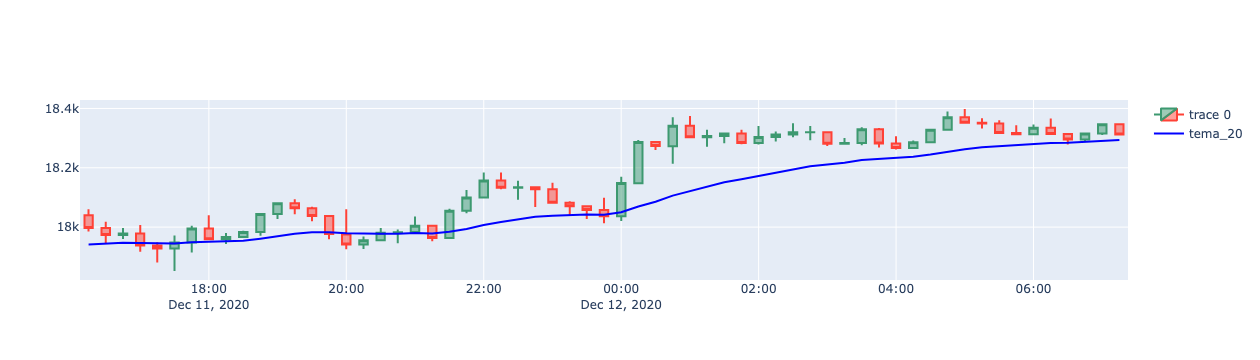

In [77]:
import plotly.graph_objects as go

center = 1055
radius = 30
sub = dst[center - radius:center + radius + 1].copy()
fig = plot_df_interactive(sub)

fig.add_trace(go.Scatter(x=sub['Date'], y=sub['ema_24'], type='scatter', mode='lines', line=dict(color='blue'), name='tema_20'))
# fig.add_trace(go.Scatter(x=sub['Date'], y=sub['tema_50'], type='scatter', mode='lines', line=dict(color='green'), name='tema_50'))
fig.show()

## BBANDS - Bollinger Bands
Rango en los cuales se mueve el precio (media y desviaciones)
Por debajo de la banda inferior puede indicar subida, por encima puede indicar bajada

## DEMA - Double Exponential Moving Average
https://www.daytradetheworld.com/trading-blog/double-exponential-moving-average-dema/
Indicador de tendencia. Precios por encima de la DEMA ayudan a confirmar up trend, por debajo confirman down-trend.
Usar 2, una short term y otro long term. Cuando se cruzan puede indicar reversal.

## EMA - Exponential Moving Average
Indicador de tendencia, cruces del precio con la EMA pueden indicar reversal.

## HT_TRENDLINE - Hilbert Transform - Instantaneous Trendline
?

## KAMA - Kaufman Adaptive Moving Average
Otro indicador de tendencia. Controlar cruces.

## MA - Moving average
..

## MAMA - MESA Adaptive Moving Average
..

## SAREXT -Parabolic SAR - Extended
## SMA -Simple Moving Average
?